# Dogs vs. Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import numpy as np
import keras
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


In [3]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

In [4]:
IMG_SIZE = (299, 299)  # размер входного изображения сети

## Функции загрузки данных

In [5]:
import re
from random import shuffle
from glob import glob

train_files = glob('./data/train/*.jpg')
test_files = glob('./data/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*dog\.\d+.*', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

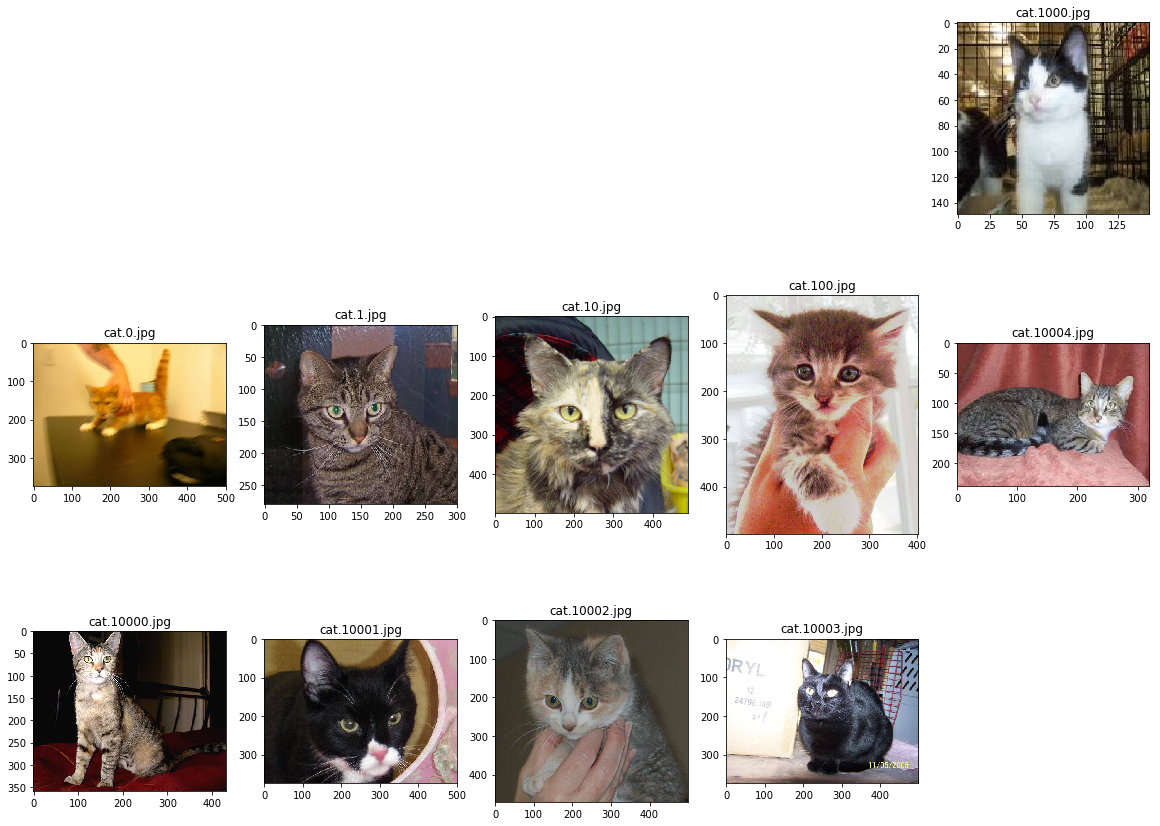

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [7]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = InceptionV3(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

87801856/87910968 [============================>.] - ETA: 0s   

In [75]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

## Добавляем полносвязный слой

In [76]:
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1,  # один выход
                       activation='sigmoid',  # функция активации  
                       kernel_regularizer=keras.regularizers.l1(1e-4))(x)
model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [77]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 149, 149, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 149, 149, 32)  96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 149, 149, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

## Компилируем модель и запускаем обучение

In [78]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy', 'binary_crossentropy'])

In [80]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 1000  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
                    steps_per_epoch=5,  # число вызовов генератора за эпоху
                    epochs=20,  # число эпох обучения
                    validation_data=validation_data)

Epoch 1/20
5/5 [==============================] - 336s - loss: 0.5471 - acc: 0.9313 - binary_crossentropy: 0.4975 - val_loss: 0.2881 - val_acc: 0.9530 - val_binary_crossentropy: 0.2369
Epoch 2/20
5/5 [==============================] - 337s - loss: 0.4753 - acc: 0.9500 - binary_crossentropy: 0.4231 - val_loss: 0.4003 - val_acc: 0.9270 - val_binary_crossentropy: 0.3467

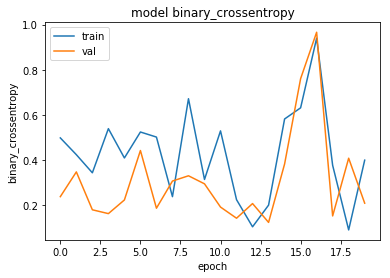

In [81]:
plt.plot(model.history.history['binary_crossentropy'])
plt.plot(model.history.history['val_binary_crossentropy'])
plt.title('model binary_crossentropy')
plt.ylabel('binary_crossentropy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Предсказания на проверочной выборке

In [82]:
%%time
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)
pred = np.clip(pred,0.0125,0.9875)

CPU times: user 6h 34min 47s, sys: 26min 58s, total: 7h 1min 46s
Wall time: 1h 3min 54s


## Готовим данные для сабмита

In [83]:
with open('submit_inception_clipped_20ep.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

In [ ]:
# LogLoss = 0.14183